In [7]:
# STEP 1: Install dependencies
!pip install -q pandas numpy matplotlib

import zipfile
import json
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

# STEP 2: Upload zipped JSON file
from google.colab import files
uploaded = files.upload()  # Upload your .zip file

# STEP 3: Unzip the file
import os
import io

for fn in uploaded.keys():
    if fn.endswith(".zip"):
        with zipfile.ZipFile(io.BytesIO(uploaded[fn]), 'r') as zip_ref:
            zip_ref.extractall("/content/data")
        print(f"Extracted {fn} to /content/data")

# STEP 4: Load JSON
json_path = "/content/data/user-wallet-transactions.json"
with open(json_path) as f:
    transactions = json.load(f)

# STEP 5: Feature extraction
def extract_wallet_features(transactions):
    wallet_data = defaultdict(list)

    for tx in transactions:
        wallet = tx.get("userWallet")
        action = tx.get("action")
        ts = tx.get("timestamp")
        data = tx.get("actionData", {})
        amount = float(data.get("amount", 0))
        price_usd = float(data.get("assetPriceUSD", 1.0))
        amount_usd = amount * price_usd

        wallet_data[wallet].append({
            'timestamp': ts,
            'action': action,
            'amount_usd': amount_usd
        })

    feature_rows = []

    for wallet, txs in wallet_data.items():
        txs = sorted(txs, key=lambda x: x['timestamp'])
        actions = defaultdict(list)
        timestamps = []

        for tx in txs:
            actions[tx['action']].append(tx['amount_usd'])
            timestamps.append(tx['timestamp'])

        deposit = sum(actions.get("deposit", []))
        borrow = sum(actions.get("borrow", []))
        repay = sum(actions.get("repay", []))
        redeem = sum(actions.get("redeemunderlying", []))
        liquidations = len(actions.get("liquidationcall", []))

        repay_borrow_ratio = repay / borrow if borrow > 0 else 0
        redeem_deposit_ratio = redeem / deposit if deposit > 0 else 0
        tx_count = len(timestamps)
        avg_time_diff = np.mean(np.diff(timestamps)) if len(timestamps) > 1 else 0

        feature_rows.append({
            'wallet': wallet,
            'total_deposit_usd': deposit,
            'total_borrow_usd': borrow,
            'total_repay_usd': repay,
            'total_redeem_usd': redeem,
            'repay_borrow_ratio': repay_borrow_ratio,
            'redeem_deposit_ratio': redeem_deposit_ratio,
            'num_liquidations': liquidations,
            'tx_count': tx_count,
            'avg_time_diff': avg_time_diff
        })

    return pd.DataFrame(feature_rows)

features_df = extract_wallet_features(transactions)

# STEP 6: Scoring logic (simple weighted formula)
from sklearn.preprocessing import MinMaxScaler

def compute_scores(df):
    score_df = df.copy()
    scaler = MinMaxScaler()

    score_df['repay_borrow_ratio'] = score_df['repay_borrow_ratio'].fillna(0)
    score_df['redeem_deposit_ratio'] = score_df['redeem_deposit_ratio'].fillna(0)
    score_df['avg_time_diff'] = score_df['avg_time_diff'].replace(0, 1)

    score_df['deposit_scaled'] = scaler.fit_transform(score_df[['total_deposit_usd']])
    score_df['redeem_ratio_scaled'] = scaler.fit_transform(score_df[['redeem_deposit_ratio']])
    score_df['repay_ratio_scaled'] = scaler.fit_transform(score_df[['repay_borrow_ratio']])
    score_df['tx_count_scaled'] = scaler.fit_transform(score_df[['tx_count']])
    score_df['liquidation_penalty'] = 1 - scaler.fit_transform(score_df[['num_liquidations']])
    score_df['time_diff_scaled'] = scaler.fit_transform(score_df[['avg_time_diff']])

    # Weighted score (0–1000)
    score_df['score'] = (
        0.25 * score_df['deposit_scaled'] +
        0.2 * score_df['repay_ratio_scaled'] +
        0.15 * score_df['redeem_ratio_scaled'] +
        0.15 * score_df['tx_count_scaled'] +
        0.15 * score_df['liquidation_penalty'] +
        0.1 * score_df['time_diff_scaled']
    ) * 1000

    return score_df[['wallet', 'score']].sort_values(by='score', ascending=False)

scored_df = compute_scores(features_df)
scored_df.head()


Saving user-wallet-transactions.json.zip to user-wallet-transactions.json.zip
Extracted user-wallet-transactions.json.zip to /content/data


,wallet,score
137,0x0034baeeb160a5f1032b6d124d3e87cc94d74e62,460.439863
54,0x000f7f22bfc28d940d4b68e13213ab17cf107790,378.284869
2723,0x04be2a942c1060db1c7615670bb55950a52f8b15,350.064060
3178,0x058b10cbe1872ad139b00326686ee8ccef274c58,336.752264
1299,0x022b3fa410364e1e28054b704b0da3b67aa6dc90,325.949176


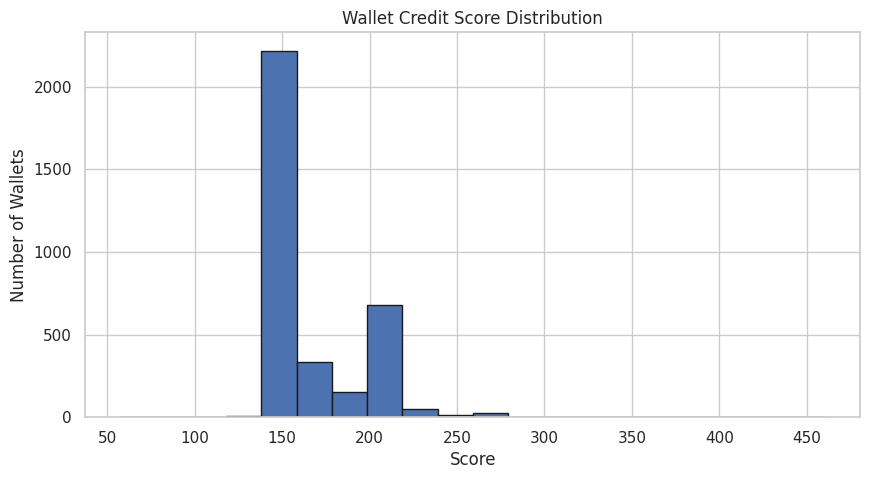

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
# Plot score distribution
plt.figure(figsize=(10, 5))
plt.hist(scored_df['score'], bins=20, edgecolor='k')
plt.title("Wallet Credit Score Distribution")
plt.xlabel("Score")
plt.ylabel("Number of Wallets")
plt.grid(True)
plt.show()

# Export to CSV
scored_df.to_csv("wallet_scores.csv", index=False)
files.download("wallet_scores.csv")


In [12]:
# Score buckets
bucket_ranges = [(0, 199), (200, 399), (400, 599), (600, 799), (800, 899), (900, 1000)]
bucket_labels = ["0–199", "200–399", "400–599", "600–799", "800–899", "900–1000"]

bucket_data = []

total_wallets = len(scored_df)

for (low, high), label in zip(bucket_ranges, bucket_labels):
    count = ((scored_df['score'] >= low) & (scored_df['score'] <= high)).sum()
    percent = round((count / total_wallets) * 100, 2)
    bucket_data.append({
        'Score Range': label,
        '# Wallets': count,
        '% of Total': percent
    })

bucket_df = pd.DataFrame(bucket_data)
print(bucket_df)

  Score Range  # Wallets  % of Total
0       0–199       2724       77.90
1     200–399        766       21.90
2     400–599          1        0.03
3     600–799          0        0.00
4     800–899          0        0.00
5    900–1000          0        0.00
